# This notebook does not require intensive computational power and can be run on the laptop.
## best way to run it would be installing anaconda, creating an new environment (conda env create -n gradient_boost python=3.7) and installling the necessary packages through conda (conda install seaborn shap lightgbm sklearn)
## to read notebook we sugest using jupyter lab

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":30,"axes.titlesize":20,"axes.labelsize":20},style="white", context='paper')
import matplotlib.pyplot as plt
import shap


# trim header from vcf file

In [2]:
import shutil

In [9]:
import shutil

source_file = open('data/WIFL_final.vcf', 'r')
for i in range(7818): source_file.readline()
# this will truncate the file, so need to use a different file name:
target_file = open('genotype_matrix.tsv', 'w')

shutil.copyfileobj(source_file, target_file)

# read vcf, trim column labels, fix indexes, get sum alleles and add NaNs

In [3]:
%%time 
vcf = pd.read_csv('genotype_matrix.tsv', sep='\t', low_memory=False )

CPU times: user 15.3 s, sys: 852 ms, total: 16.1 s
Wall time: 16.2 s


In [4]:
%%time
genotypes = vcf.iloc[:, 9:]


CPU times: user 175 ms, sys: 64 µs, total: 175 ms
Wall time: 173 ms


In [5]:
index = vcf['#CHROM'] + +vcf.POS.apply(lambda x: '-'+str(x)) ### check this

In [6]:
genotypes = genotypes.T

In [7]:
genotypes.columns = index.values

In [8]:
def adjust(string):
    if string[0] == '.': return None
    return round(int(string[0])+ int(string[2]))

In [9]:
genotypes = genotypes.applymap(adjust)

In [11]:
#genotypes

### check how many NaN there are per column, plot histogram, and trim columns with more than 10% nans or minor allelle frequency < 10%

In [12]:
print(genotypes.shape)
genotypes_dalf = genotypes.loc[:, ( genotypes.mean(axis=0)/2>=.1) & (genotypes.mean(axis=0)/2 <=.9)]
print(genotypes_dalf.shape)

(175, 105000)
(175, 37856)


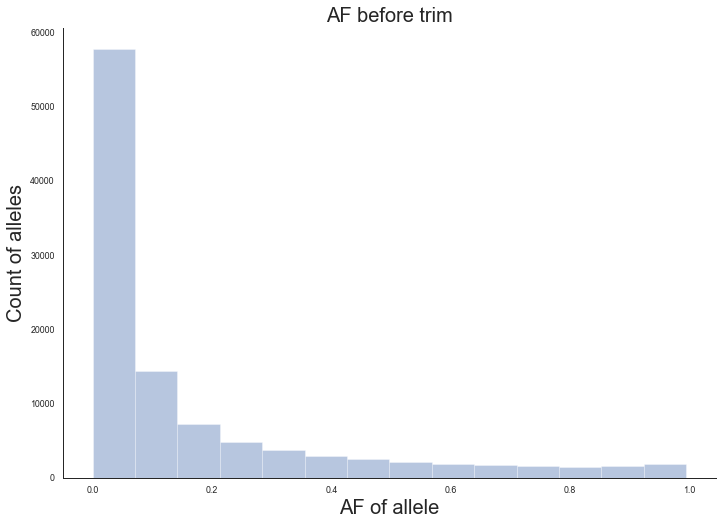

In [15]:
plt.title('AF before trim')
sns.distplot(genotypes.mean(axis=0).values/2, bins=14, kde=False)
plt.xlabel('AF of allele')
plt.ylabel('Count of alleles')
sns.despine()

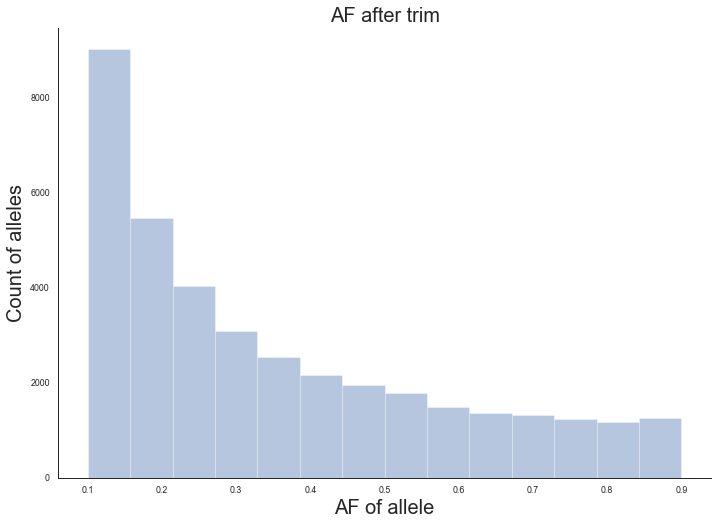

In [16]:
plt.title('AF after trim')
sns.distplot(genotypes_dalf.mean(axis=0).values/2, bins=14, kde=False)
plt.xlabel('AF of allele')
plt.ylabel('Count of alleles')
sns.despine()

In [17]:
genotypes_trimmed = genotypes_dalf.loc[:, (genotypes_dalf.isnull().sum(axis=0)/genotypes.shape[0] < .1)]

In [18]:
genotypes_trimmed.shape

(175, 37856)

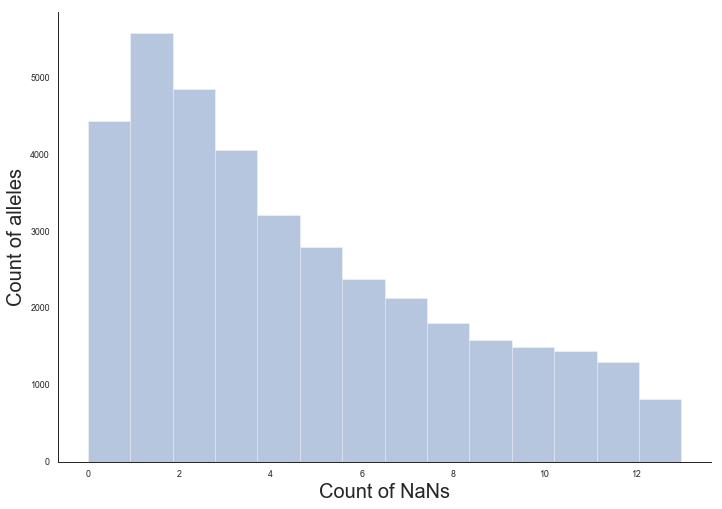

In [19]:
sns.distplot(genotypes_dalf.isnull().sum(axis=0).values, bins=14, kde=False)
plt.xlabel('Count of NaNs')
plt.ylabel('Count of alleles')
sns.despine()

In [20]:
# fill nans with mean value
genotypes_final = genotypes_trimmed.fillna(genotypes_trimmed.mean())
genotypes_final = genotypes_final.applymap(lambda x: int(round(x, 0)))

## drop last samples to match with the given environmental file given by rachael

In [21]:
print(genotypes_final.shape)
genotypes_FF = genotypes_final.iloc[:171, :]
print(genotypes_FF.shape)


(175, 37856)
(171, 37856)


# import environmental factors

In [22]:
enviromnent = pd.read_csv('LFMM_environ_input.tsv', sep='\t', header=None)
enviromnent.columns = ['BIO' + str(i) for i in range(1,21)]

In [23]:
enviromnent.shape

(171, 20)

# normalize environmental factors

In [24]:
from sklearn.preprocessing import StandardScaler
environment_norm = pd.DataFrame(StandardScaler().fit_transform(enviromnent))
environment_norm.columns = ['BIO' + str(i) for i in range(1,21)]

/home/thiagoms/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/thiagoms/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [25]:
environment_norm.shape

(171, 20)

## dimensionality reduction for environment and genotypes

In [26]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### dim reduction for environment

In [300]:
pca = PCA(n_components=8)
env_pca = pca.fit_transform(environment_norm)
print(pca.explained_variance_ratio_.sum())
env_pca = pd.DataFrame(env_pca)
env_pca.columns = ['PC'+ str(i) for i in range(1,9)]

0.9923939961548166


### dim reduction for genetic data

In [296]:
tsvd = TruncatedSVD(n_components=160)

In [298]:
gen_tsvd = tsvd.fit_transform(genotypes_FF)
print(tsvd.explained_variance_ratio_.sum())

0.9711668511161017


In [349]:
gpca = PCA(n_components=3)
gen_pca = gpca.fit_transform(genotypes_FF)
gen_pca = pd.DataFrame(gen_pca)
gen_pca.columns = ['PCA' + str(i) for i in range(1,4)]
print(gpca.explained_variance_ratio_.sum())


0.08655654949911358


In [3]:
## 3 first PCS correspond to 8.6% of the genetic variance. It's an expected value and necessary to be able to plot in 3 color dimensions

# using light gdm for ML 
## input will be environmental paramenters and use classifier to predict the allele of the locus
## for every single snp will have to do a different train/test
## keep all the snp classifiers that have more than 70% acc and is not just guessing most common variant for test 


In [317]:
#import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [318]:
environment_redux = enviromnent[['BIO'+ str(i) for i in [2,3,4,5,8,9,11,15,17,18]]]

In [319]:
X_train, X_test, Y_train, Y_test = train_test_split( environment_redux,genotypes_FF, test_size=.1, random_state=42) # env_pca, genotypes_FF

In [320]:
params = {
    "max_bin": 255,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    #'is_unbalance': 'true',
    "objective": "multiclass",
    'num_classes': 3,
    'metric': 'multi_logloss',
    "num_leaves": 10,
    "verbose": -1,
    #"min_data": 1,
    #"boost_from_average": True
}



In [321]:
### check if model is not just guessing most common allele
def is_good_model(p):
    for i in p:
        if i != p[0]: return True
    return False

In [322]:
%%time 
%%capture
model_list = []
acc_list = []
good_list = []
Num = 30000
#with 30000 this will take a while

for i in range(Num):#
    miniY_train = Y_train.iloc[:, i]
    miniY_test = Y_test.iloc[:,i]
    d_train = lgb.Dataset(X_train, label=miniY_train)
    d_test = lgb.Dataset(X_test, label=miniY_test)
    ##train
    model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
    model_list += [model]
    ##find accuracy of method
    preds = model.predict(X_test)
    predictions = []
    for x in preds:
        predictions.append(np.argmax(x))
    acc_list += [1- (predictions- miniY_test).apply(lambda x: abs(x)).sum()/len(miniY_test)]
    good_list += [is_good_model(predictions)]

CPU times: user 2min 45s, sys: 1min 33s, total: 4min 18s
Wall time: 1min 11s


In [261]:
scr = pd.DataFrame({'valid': good_list, 'accuracy': acc_list, 'model': model_list})


In [262]:
%%time
scr.index = Y_train.columns[:Num]
scr.to_pickle("model list boosted gradient forest.p")

CPU times: user 24.2 s, sys: 4.97 s, total: 29.2 s
Wall time: 8.55 s


/home/thiagoms/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


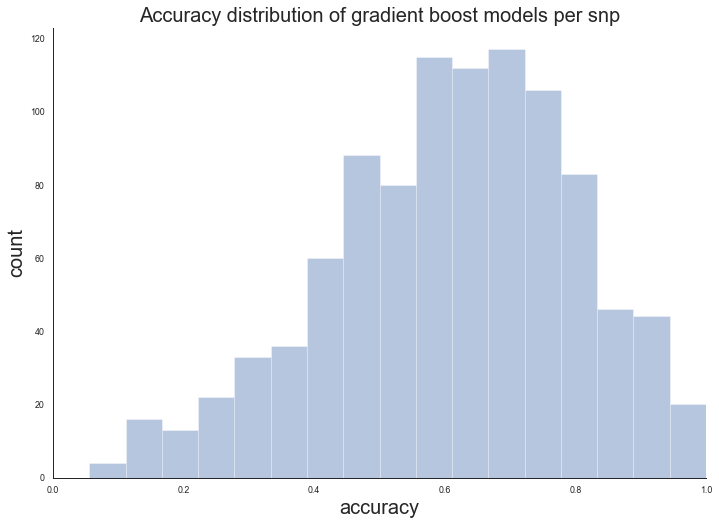

In [263]:
sns.distplot(scr.accuracy, kde = False)
plt.xlim([0,1])
plt.title('Accuracy distribution of gradient boost models per snp')
plt.ylabel('count')
sns.despine()

/home/thiagoms/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


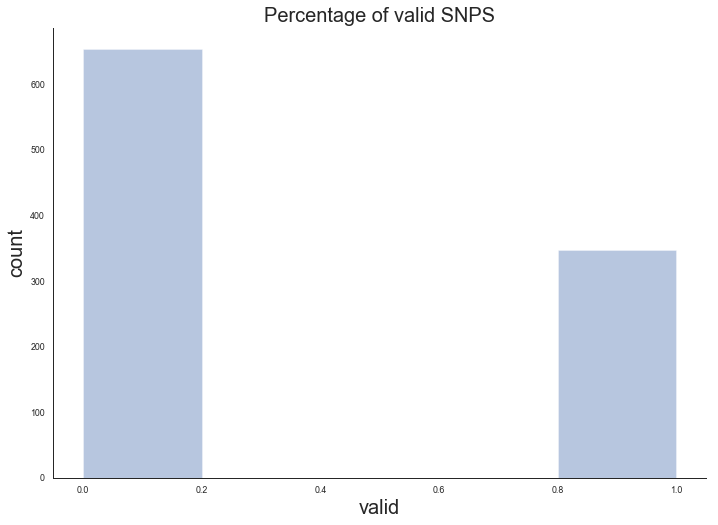

In [264]:
sns.distplot(scr.valid.apply(lambda x: 1 if x == True else 0), kde = False)
#plt.xlim([0,1])
plt.title('Percentage of valid SNPS')
plt.ylabel('count')
sns.despine()

In [265]:
subset = scr[(scr['valid']== True) & (scr['accuracy'] > .7)]

In [266]:
subset.shape

(59, 3)

# calculate percentage of valid SNPS with good acc

In [267]:
subset.shape[0]/scr.shape[0]*100

5.8999999999999995

# using SHAP to estimate the most important environmental predictor distribution for last snp

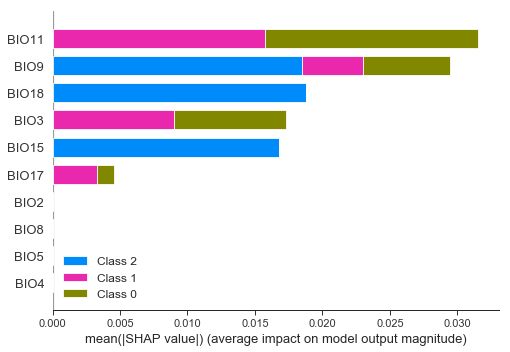

In [243]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [244]:
(np.array(shap_values)).shape

(3, 153, 10)

In [246]:
all_shap = pd.DataFrame((np.array(shap_values)[0,:,:]) + (np.array(shap_values)[1,:,:]) + (np.array(shap_values)[2,:,:]))
all_shap.columns = ['BIO'+ str(i) for i in [2,3,4,5,8,9,11,15,17,18]] #['BIO' + str(i) for i in range(1,21)]

In [247]:
#sns.heatmap(all_shap)

# estimate important enviroments for all snps

In [248]:
def shap_importance(md):
    try:
        explainer = shap.TreeExplainer(md)
        shap_values = explainer.shap_values(X_train)
        return (np.array(shap_values)[0,:,:]) + (np.array(shap_values)[1,:,:]) + (np.array(shap_values)[2,:,:])
    except: return 

In [249]:
%%time
#subset['shap_imp'] = subset.model.apply(shap_importance)
subset['shap_imp'] = subset.model.apply(shap_importance)

CPU times: user 45 s, sys: 10.6 s, total: 55.6 s
Wall time: 26.7 s


/home/thiagoms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [250]:
tot_shap = subset.shap_imp.values

In [251]:
final_shap = tot_shap[0]
counter = 0
for i in tot_shap:
    try:final_shap += i
    except: 
        print(counter)
        counter +=1

In [253]:
final_shap_df = pd.DataFrame(final_shap)
final_shap_df.columns = ['BIO'+ str(i) for i in [2,3,4,5,8,9,11,15,17,18]] #['BIO' + str(i) for i in range(1,21)]
final_shap_df_abs = final_shap_df.applymap(lambda x: abs(x))

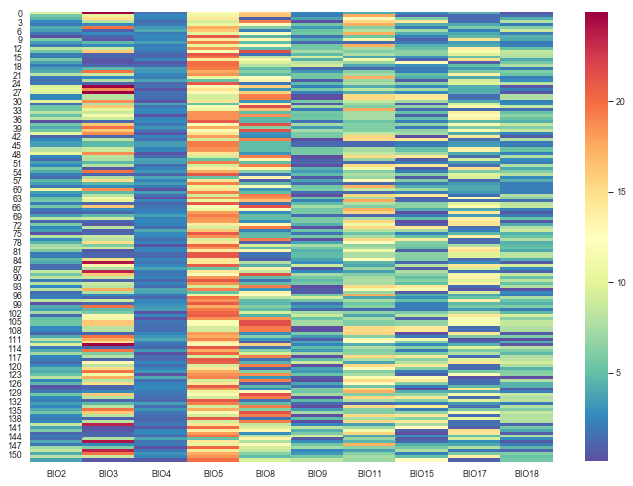

In [254]:
sns.heatmap(final_shap_df_abs,  cmap='Spectral_r')

In [307]:
final_shap_df_abs.mean().sort_values(ascending = False)

BIO5     15.272118
BIO8      9.641701
BIO3      9.148645
BIO11     8.974258
BIO17     6.763590
BIO15     5.527188
BIO18     4.917903
BIO2      4.289667
BIO9      3.995441
BIO4      2.152954
dtype: float64

# use light gbm for l2 regression over compressed genome (using PCA with n_components = 3)

In [328]:
X_train, X_test, Y_train, Y_test = train_test_split( environment_redux,gen_pca, test_size=.1, random_state=42) # env_pca, genotypes_FF
params_reg = {
    "max_bin": 255,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    #'is_unbalance': 'true',
    "objective": "regression_l2",
    'metric': 'l2',
    "num_leaves": 10,
    "verbose": -1,
    #"min_data": 1,
    #"boost_from_average": True
}

In [358]:
model_list = []
for i in range(gen_pca.shape[1]):#
    miniY_train = Y_train.iloc[:, i]
    miniY_test = Y_test.iloc[:,i]
    d_train = lgb.Dataset(X_train, label=miniY_train)
    d_test = lgb.Dataset(X_test, label=miniY_test)
    ##train
    model = lgb.train(params_reg, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
    model_list += [model]
    ##find accuracy of method
    #print(miniY_test.values-model.predict(X_test))/miniY_test.values


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[303]	valid_0's l2: 177.082
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[15]	valid_0's l2: 241.186
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[269]	valid_0's l2: 376.782


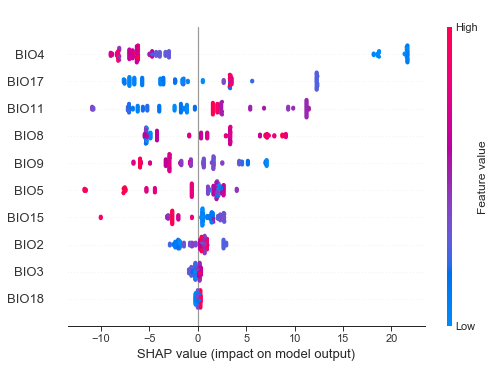

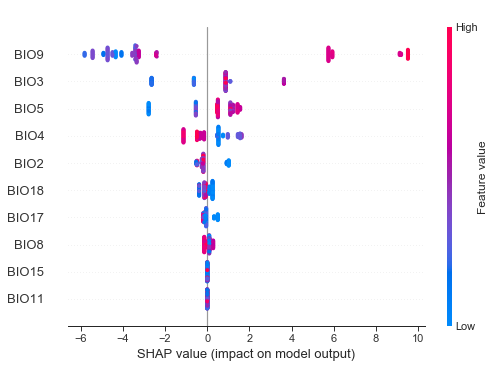

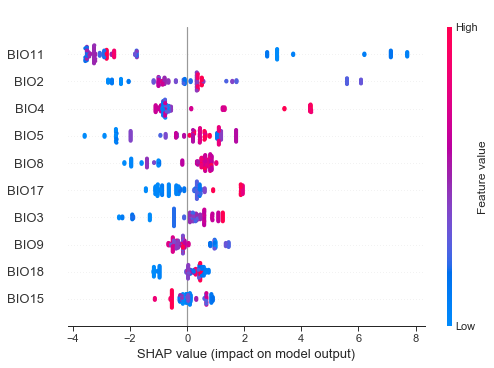

In [639]:
for model in model_list:
    shap.initjs()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train)

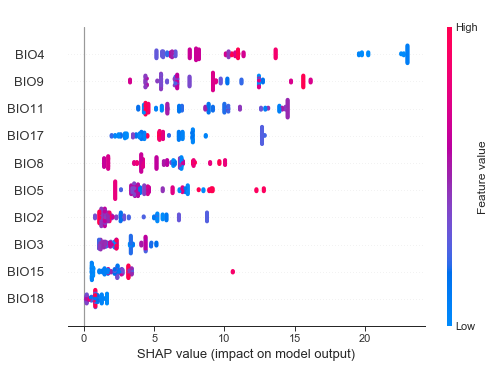

In [645]:

shap.initjs()
chapa = abs(shap.TreeExplainer(model_list[0]).shap_values(X_train)) + abs(shap.TreeExplainer(model_list[1]).shap_values(X_train)) + abs(shap.TreeExplainer(model_list[2]).shap_values(X_train)) 

shap.summary_plot(chapa, X_train)

In [644]:
abs(shap.TreeExplainer(model_list[1]).shap_values(X_train) )

array([[0.18714079, 2.63885135, 0.52970529, ..., 0.        , 0.05236559,
        0.07967382],
       [0.48806989, 0.87256105, 0.4685051 , ..., 0.        , 0.0921908 ,
        0.38579722],
       [0.2238416 , 0.63391888, 1.62498087, ..., 0.        , 0.14321254,
        0.1377219 ],
       ...,
       [0.49393831, 0.87256105, 0.48793846, ..., 0.        , 0.10114411,
        0.25076819],
       [0.18714079, 3.63555146, 0.14967458, ..., 0.        , 0.05236559,
        0.09298298],
       [0.18714079, 3.63555146, 0.52970529, ..., 0.        , 0.05236559,
        0.07967382]])

In [368]:
modelpca1 = model_list[0]
modelpca2 = model_list[1]
modelpca3 = model_list[2]

# now predict all genetics for random environments

In [602]:
future_env = pd.read_csv('wiflfuture2-6-2050.csv')

In [442]:
future_env_minus_loc = future_env.iloc[:, 2:]
future_env_redux = future_env.iloc[:10000, :]

In [603]:
%%time
future_env['predicted PCA1'] = future_env.apply(lambda row: modelpca1.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)
future_env['predicted PCA2'] = future_env.apply(lambda row: modelpca2.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)
future_env['predicted PCA3'] = future_env.apply(lambda row: modelpca3.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)

CPU times: user 3min 38s, sys: 2min 52s, total: 6min 30s
Wall time: 1min 46s


In [604]:
future_env_bios = future_env.iloc[:, 2:12]
future_env_bios = pd.DataFrame(StandardScaler().fit_transform(future_env_bios))


/home/thiagoms/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/thiagoms/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [605]:
pcaUSBios = PCA(n_components=3)
future_env_bios_compressed = pd.DataFrame(pcaUSBios.fit_transform(future_env_bios), columns = ['BIO-PCA1', 'BIO-PCA2', 'BIO-PCA3'])

In [606]:
final_US_env = pd.concat([future_env,future_env_bios_compressed], axis = 1)

## adjust pca values to rgb

In [607]:
from sklearn.preprocessing import MinMaxScaler
rgbscaler1 = MinMaxScaler()
rgbscaler2 = MinMaxScaler()
rgbscaler3 = MinMaxScaler()

In [608]:
a =rgbscaler1.fit_transform(final_US_env['predicted PCA1'].values.reshape(-1, 1))
b = rgbscaler2.fit_transform(final_US_env['predicted PCA2'].values.reshape(-1, 1))
c = rgbscaler3.fit_transform(final_US_env['predicted PCA3'].values.reshape(-1, 1))

In [609]:
final_US_env['predictedPCA1'] = [int(255*i) for i in a]
final_US_env['predictedPCA2'] = [int(255*i) for i in b]
final_US_env['predictedPCA3'] = [int(255*i) for i in c]

In [610]:
final_US_env['rgb'] = final_US_env.apply(lambda row: [row['predictedPCA1'], row['predictedPCA2'], row['predictedPCA3']], axis =1)

In [611]:
final_US_env.to_csv('USmapFuture')

In [502]:
plt.scatter(x = final_US_env['BIO-PCA1'].values, y = final_US_env['BIO-PCA2'].values, c = final_US_env['rgb'].values)

In [492]:
final_US_env['rgb'].values

array([list([63, 51, 124]), list([93, 23, 126]), list([74, 62, 133]), ...,
       list([23, 254, 111]), list([10, 254, 128]), list([74, 62, 133])],
      dtype=object)

# do for present and future environments

In [513]:
current_env = pd.read_csv('wiflcurrentRH.csv')

In [514]:
%%time
current_env['predicted PCA1'] = current_env.apply(lambda row: modelpca1.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)
current_env['predicted PCA2'] = current_env.apply(lambda row: modelpca2.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)
current_env['predicted PCA3'] = current_env.apply(lambda row: modelpca3.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)

CPU times: user 3min 35s, sys: 2min 50s, total: 6min 26s
Wall time: 1min 44s


In [516]:
future_env = pd.read_csv('wiflfuture2-6-2050.csv')

In [517]:
%%time
future_env['predicted PCA1'] = future_env.apply(lambda row: modelpca1.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)
future_env['predicted PCA2'] = future_env.apply(lambda row: modelpca2.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)
future_env['predicted PCA3'] = future_env.apply(lambda row: modelpca3.predict([np.array([row[i] for i in range(2, 12)])])[0], axis=1)

CPU times: user 3min 31s, sys: 2min 43s, total: 6min 14s
Wall time: 1min 38s


In [518]:
current_env['timeline'] = current_env['predicted PCA1'].apply(lambda x: 'now')
future_env['timeline'] = future_env['predicted PCA1'].apply(lambda x: 'future')


In [521]:
all_env = pd.concat([current_env, future_env], axis = 0)

In [535]:
env_bios = all_env.iloc[:, 2:12]
env_bios = pd.DataFrame(StandardScaler().fit_transform(env_bios))
pcaUSBios = PCA(n_components=3)
env_bios_compressed = pd.DataFrame(pcaUSBios.fit_transform(env_bios), columns = ['BIO-PCA1', 'BIO-PCA2', 'BIO-PCA3'])
US_env_pred = pd.concat([all_env.reset_index(drop=True),env_bios_compressed.reset_index(drop=True)], axis = 1 )

/home/thiagoms/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/thiagoms/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [572]:
now_df = US_env_pred[US_env_pred.timeline == 'now'].reset_index(drop=True)
future_df = US_env_pred[US_env_pred.timeline == 'future'].reset_index(drop=True)

In [573]:
now_df.to_csv('final_now_genotypes.csv')
future_df.to_csv('final_future_genotypes.csv')


# use CSV file in kepler.gl (website) and use hexagon heatmap to plot every genetic-pca in one color, that would be a spatial representation of the expected genome of individuals given the environmental parameters from world clim. This plot only accounts for 8% of the genetic variance and maping for other genomic regions can be done by using more PC's in the dimensionality reduction step and using other PC's instead of the first 3

In [574]:
genc = now_df[['predicted PCA1', 'predicted PCA2', 'predicted PCA3']]
genf = future_df[['predicted PCA1', 'predicted PCA2', 'predicted PCA3']]
genc['vector'] = genc.apply(lambda x : [x['predicted PCA1'], x['predicted PCA2'], x['predicted PCA3']], axis = 1)
genf['vector'] = genf.apply(lambda x : [x['predicted PCA1'], x['predicted PCA2'], x['predicted PCA3']], axis = 1)


/home/thiagoms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/thiagoms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# calculate genomic vulnerability

/home/thiagoms/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [580]:
a = genc.iloc[:, 3].values
b = genf.iloc[:, 3].values

In [594]:
genetic_v = pd.Series([np.linalg.norm(np.array(a[i])-np.array(b[i])) for i in range(len(a))], index=now_df.index)

In [595]:
genetic_vulnerability = now_df.iloc[:, :2]
genetic_vulnerability['GV']= genetic_v

In [597]:
genetic_vulnerability.to_csv('genetic_vulnerability_wifl.csv')

# making that nice PCA plot

In [622]:
color_list = [np.array(x)/255 for x  in final_US_env['rgb'].values]

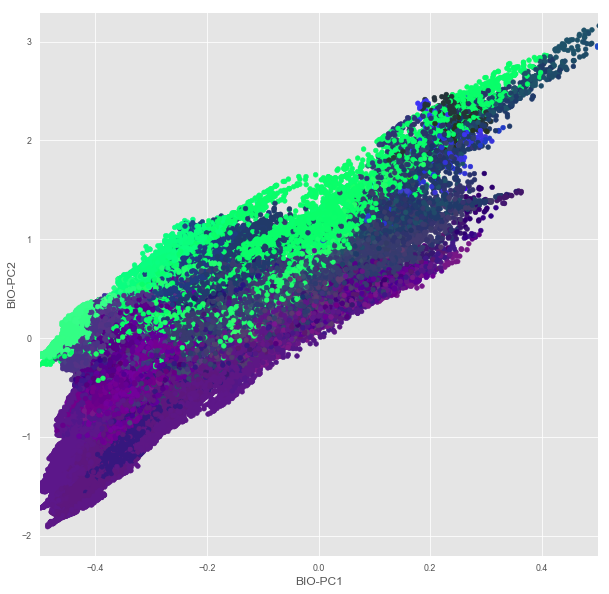

In [632]:
import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,10)



fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(final_US_env['BIO-PCA1'].values, final_US_env['BIO-PCA2'].values, color=color_list)
plt.xlim([-.5,.5])
plt.ylim([-2.2,3.3])
plt.xlabel('BIO-PC1')
plt.ylabel('BIO-PC2')

plt.show()